In [34]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import matplotlib.pyplot as plt

% matplotlib inline

In [21]:
n_inputs = 784
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.001

X=tf.placeholder(tf.float32, shape=(None, n_inputs))

with tf.contrib.framework.arg_scope(
    [fully_connected],
    activation_fn=tf.nn.elu,
    weights_initializer = tf.contrib.layers.variance_scaling_initializer(),
    weights_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)):
    hidden1=fully_connected(X, n_hidden1)
    hidden2=fully_connected(hidden1, n_hidden2)
    hidden3=fully_connected(hidden2, n_hidden3)
    outputs=fully_connected(hidden3, n_outputs, activation_fn=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

loss = tf.add_n([reconstruction_loss]+reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [22]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/data')
X_train = mnist.train.images
X_test = mnist.test.images

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [23]:
n_epoch=5
batch_size=100

with tf.Session() as sess:
    init.run()
    recon_test_bef = sess.run(reconstruction_loss, feed_dict={X:X_test})
    for epoch in range(n_epoch):
        for interation in range(mnist.train.num_examples//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            training.run(feed_dict={X:X_batch})
    recon_test_aft = sess.run(reconstruction_loss, feed_dict={X:X_test})
    
print('recon_loss_bef:{}'.format(recon_test_bef), 'recon_loss_aft:{}'.format(recon_test_aft))

recon_loss_bef:0.7856044769287109 recon_loss_aft:0.03739762306213379


In [29]:
# Implementing tying weights
n_inputs = 784
n_hidden1 = 300
n_hidden2 = 150

activation =tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32,shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])


weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.transpose(weights2, name='weights3')
weights4 = tf.transpose(weights1, name='weights4')

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

recon_loss = tf.reduce_sum(tf.square(outputs-X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = recon_loss + reg_loss

optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [58]:
X_test = mnist.test.images[0]

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epoch):
        for interation in range(mnist.train.num_examples//batch_size):
            X_train, y_train = mnist.train.next_batch(batch_size)
            train_op.run(feed_dict={X:X_train})
    recon_test = outputs.eval(feed_dict={X:X_test.reshape(-1, 784)})
    weights1_plot = weights1.eval()

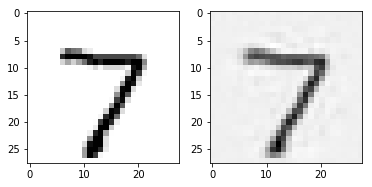

In [59]:
fig, axes = plt.subplots(1,2)
axes[1].imshow(recon_test.reshape(28,28),cmap='Greys', interpolation='nearest')
axes[0].imshow(X_test.reshape(28,28),cmap='Greys', interpolation='nearest')

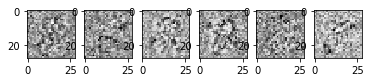

In [81]:
# Visualize features that learned by the first hidden layer
fig, axes = plt.subplots(1,6)

k = 0
    
for i in range(n_hidden1):
    if i%50 == 0:
        axes[k].imshow(weights1_plot[:,i].reshape(28,28), cmap='Greys', interpolation='nearest')
        k = k +1